### Overview of the notebook

* 1. [Introduction](#chapter1)

* 2. [PGM and generative story ](#chapter2)
    
* 3. [Data Visualizations ](#chapter3)

* 4. [Baseline Models](#chapter4)
    * 4.1 [Sklearn Linear Regression](#section_4_1)
    * 4.2 [Pyro Linear Regression](#section_4_2)
    
* 5. [Advanced models](#chapter5)
    * 5.1 [Neural Network](#section_5_1)
    * 5.2 [Neural Network + linear regression](#section_5_2)
    * 5.3 [Hierarchial models](#section_5_3)
        * 5.3.1 [Hierarchial priors for the intercept $\alpha$](#section_5_3_1)
        * 5.3.2 [Hierarchial priors for $\alpha$ and $\beta$](#section_5_3_2)
        * 5.3.3 [Hierachial $\alpha$ -  Neural Network + Linear Regression](#section_5_3_3)
 
* 6. [Discussion](#chapter6)
 
* 7. [References](#chapter7)

* 8. [Contributions](#chapter8)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
import torch
import itertools

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model

# matplotlib style options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# fix random generator seed (for reproducibility of results)
np.random.seed(42)
from numpy.random import RandomState
prng = RandomState(1234567890)

# Introduction <a class="anchor" id="chapter1"></a>


This project aims to predict what it is that makes people dance to certain songs. Spotify provides a dataset containing a number of features such as tempo, rhythm, beat, genre and strength. “Danceability” is one of the features, ranging from 0 to 1. In this project, various Machine Learning techniques will be performed on the data, aiming to predict the danceability of a song. Furthermore, it will be explored if the predictions vary between different music-genre. Could it be that certain features play a larger role in some genres then others? For example R&B tends to have lower tempo-feature compared to Reggeaton but it is still a genre with a high danceability. Moreover, could the speechiness-feature have a higher importance on predicting the danceability of a pop-song compared to others, as pop-songs tend to be popular to sing along with.

The dataset for the project was fetched from [Kaggle](https://www.kaggle.com/code/huanntran100/spotify-song-popularity-prediction/data?select=SpotifyFeatures.csv) including  232,725 songs with 18 different features for each song. The most relevant features were considered to be:

* `Popularity`
* `Acousticness`
* `Duration_ms`
* `Energy`
* `Instrumentalness`
* `Liveness`
* `Loudness`
* `Speechiness`
* `Tempo`
* `Valence` 
* `Danceability`
* `Genre`


These features were used to make predictions.

In this project predictions will be made using various different Bayesian machine learning models, starting with a simple model, Linear Regression, and adding more complexity consecutively. Finally, a Neural Network + Linear Model with hierarchical priors based on genre will be implemented. Its probabilistic graphical model (PGM) along with generative story can be seen below.



In [2]:
# read the dataset
data = pd.read_csv('SpotifyFeatures.csv')

In [3]:
# two columns called childrens music
data['genre'] = data['genre'].replace(["Children’s Music"],"Children's Music")

# PGM and Generative Story <a class="anchor" id="chapter2"></a>

Here is the generative story along with the probabilistic graphical model for the Hierarchical Neural Network + Linear model.


1. Initialize priors for the intercept for the linear model,$\alpha$, $\mu_{\alpha}\sim \mathcal{N}(0,1)$ and $\sigma_{\alpha}\sim\mathcal{N}(10)$
2. Initialize priors for Neural Network, $\theta \sim \mathcal{N}(0,\sigma_{NN}^2)$
3. Draw linear coefficients: $\boldsymbol\beta \sim \mathcal{N}(\textbf{0},10 \times \textbf{1})$
4. For each genre $g \in \{1,\dots,G\}$
    1. Draw the intercept $\alpha_g \sim \mathcal{N}(\mu_{\alpha},\sigma_{\alpha})$ 
6. For each song in $n= \{1,\dots,N\}$
    1. Draw target $y_n \sim \mathcal{N}(y_n| (\boldsymbol\beta_n^T \textbf{x}_n + \alpha_{n_g}) + f_{NN}(u_n),\theta)$

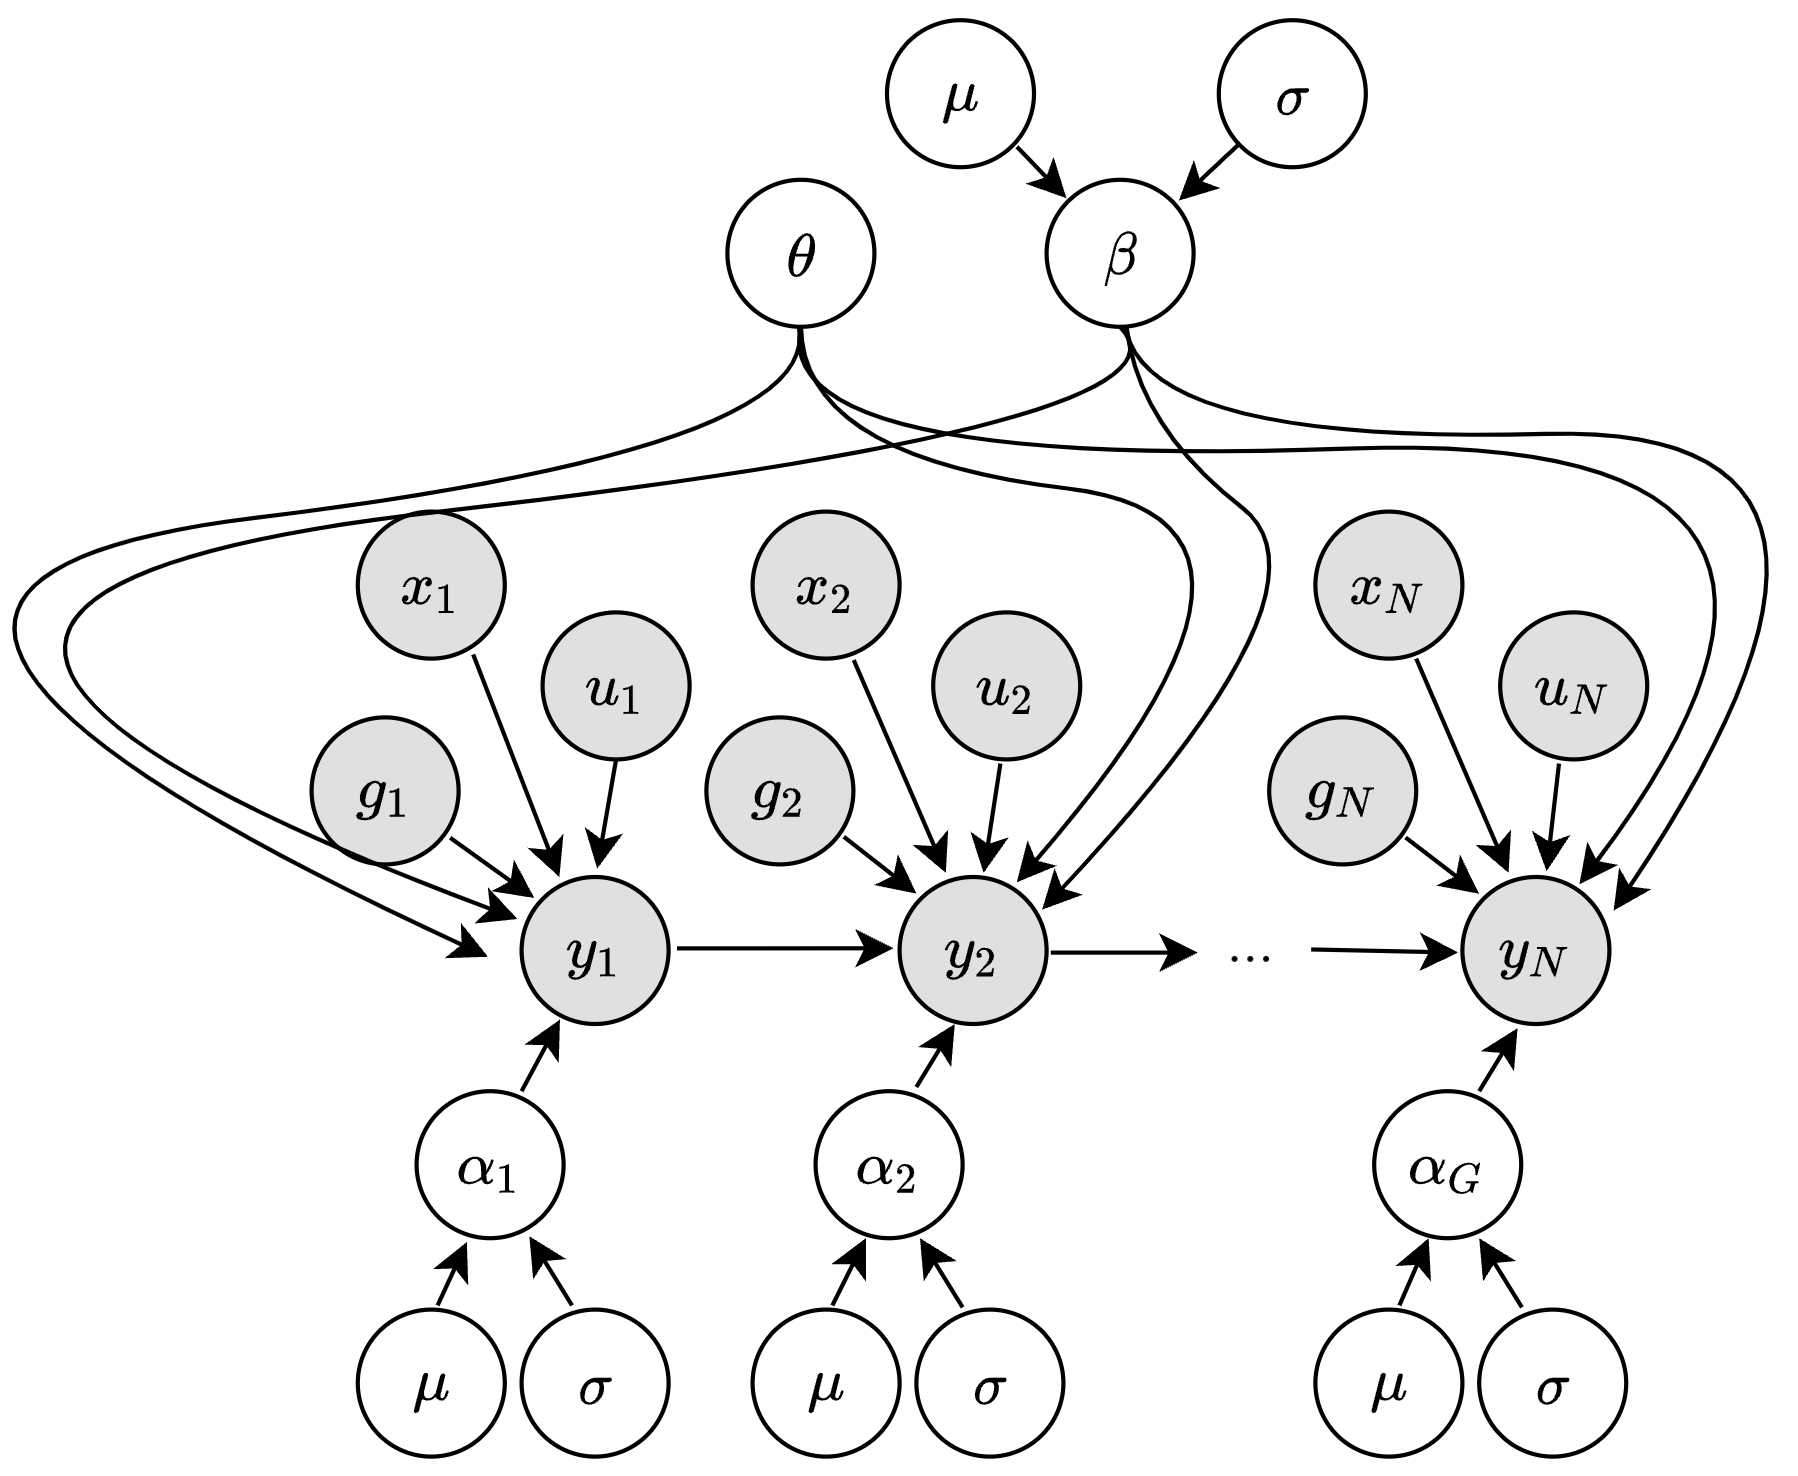

where:
* $y_n$ denotes the danceability for each observation
* $g_n$ denotes the genre each observation belongs to
* $x_n$ denotes features put in the linear model for each observation
* $u_n$ denotes features put in the neural network for each observation
* $\beta$ denotes the linear coefficients
* $\theta$ denotes the non-linear neural network coefficients
* $\alpha_g$ denotes the intercept for the linear model for each genre
* $\sigma$ and $\mu$ are the priors for the coefficients

# Data Visualizations <a class="anchor" id="chapter3"></a>

The data will now be investigated further, and visualizations will be generated to help comprehend the underlying trends. First, simple statistics are reported on the numeric columns.

In [4]:
data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


When taking a closer look at the danceability which is the target variable in the project, it is observed that the average danceability is 55.4% and the standard deviation is 18.5%, and the maximum danceability is 98.9% while the minimum is 5.0%.

The distribution of danceability is then visualized below.

In [5]:
uniqueValues, indicesList = np.unique(data.danceability, return_index=True)
new_df = data.loc[indicesList]

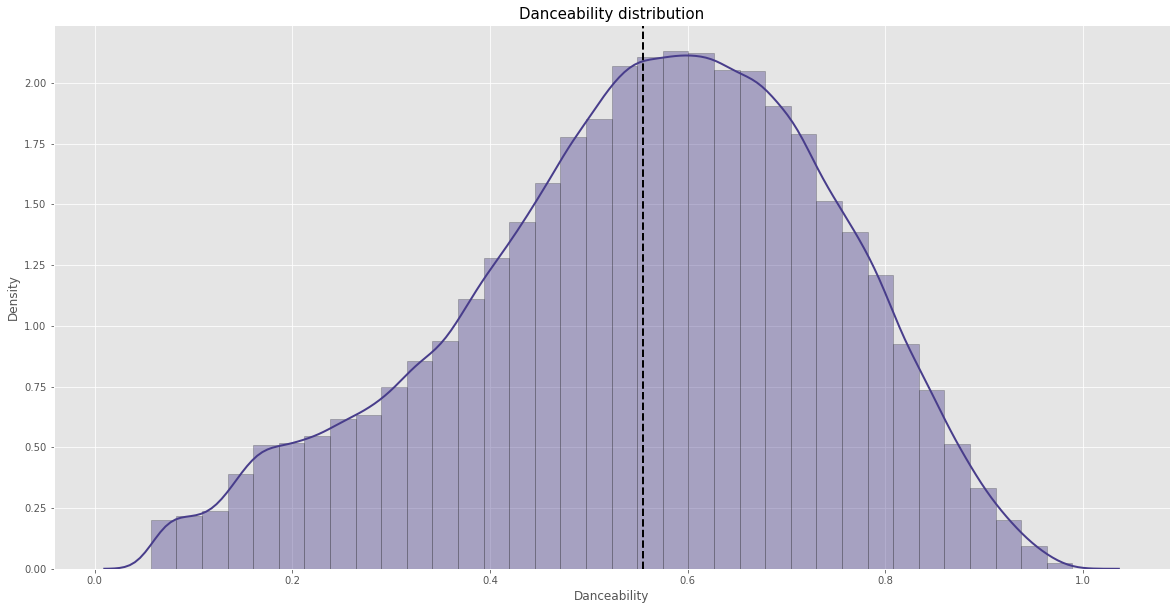

In [6]:
plt.figure(figsize=(20,10))
sns.distplot(data['danceability'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkslateblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

plt.axvline(data['danceability'].mean(), color='k', linestyle='dashed', linewidth=2)

# Plot formatting
plt.xlabel('Danceability')
plt.title('Danceability distribution', fontsize=15);

Let's then take a look at the mean danceability per genre

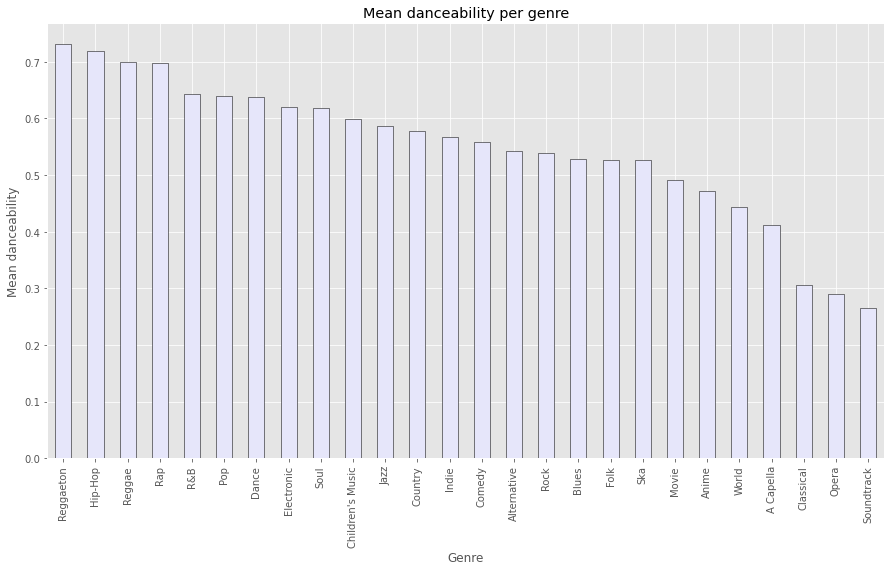

In [7]:
data.groupby('genre').mean()['danceability'].sort_values(ascending=False).plot(kind='bar',figsize=(15,8), 
                                                                        color='lavender', edgecolor='black')
plt.ylabel('Mean danceability')
plt.xlabel('Genre')
plt.title('Mean danceability per genre');

There are a lot of irrelevant genres in terms of danceability, such as Soundtrack, Opera and Classical etc. Due simplicity and relevance only the following genres were kept in the dataset to analyze further.

* `Reggeton`
* `Hip-Hop`
* `Raggae`
* `Rap`
* `R&B`
* `Pop`
* `Dance`
* `Electronic`


Let's now see how the danceability distribution is for the chosen genres along with the overall average danceability.

In [8]:
focusgenre = set(['Reggaeton', 'Hip-Hop', 'Reggae', 'Rap', 'R&B', 'Pop', 'Dance', 'Electronic'])
data = data[data['genre'].isin(focusgenre)]

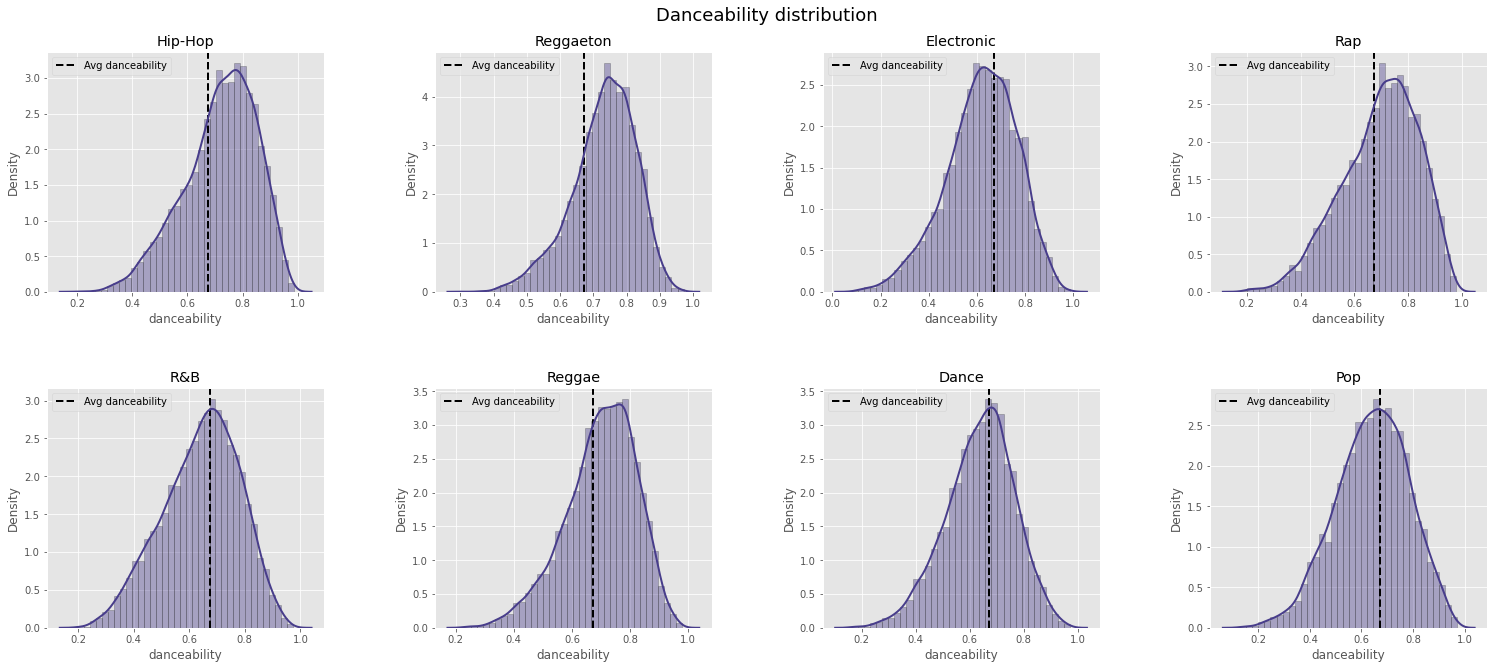

In [9]:
nrow=2
ncol=4
fig,ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(25,10))
i=0
focusgenre = list(focusgenre)
for r in range(nrow):
    for c in range(ncol):
            ax[r,c].axvline(data['danceability'].mean(), color='k', linestyle='dashed', linewidth=2)
            sns.distplot(data[data['genre'] == focusgenre[i]]['danceability'], hist=True, kde=True,
            ax = ax[r,c], 
            bins=int(180/5), color = 'darkslateblue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 2});
            
            
            ax[r,c].title.set_text(focusgenre[i])
            ax[r,c].legend(['Avg danceability'])
            i+= 1

fig.text(0.5, 0.95, 'Danceability distribution', ha='center', va='center',fontsize=18);   

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);

From the graphs above, it is clear that for most of the chosen genres the majority of songs have danceability over the total mean, which is shown as the black dashed line on the figures.

Now, the relationship between danceability and the chosen numerical features will be explored.

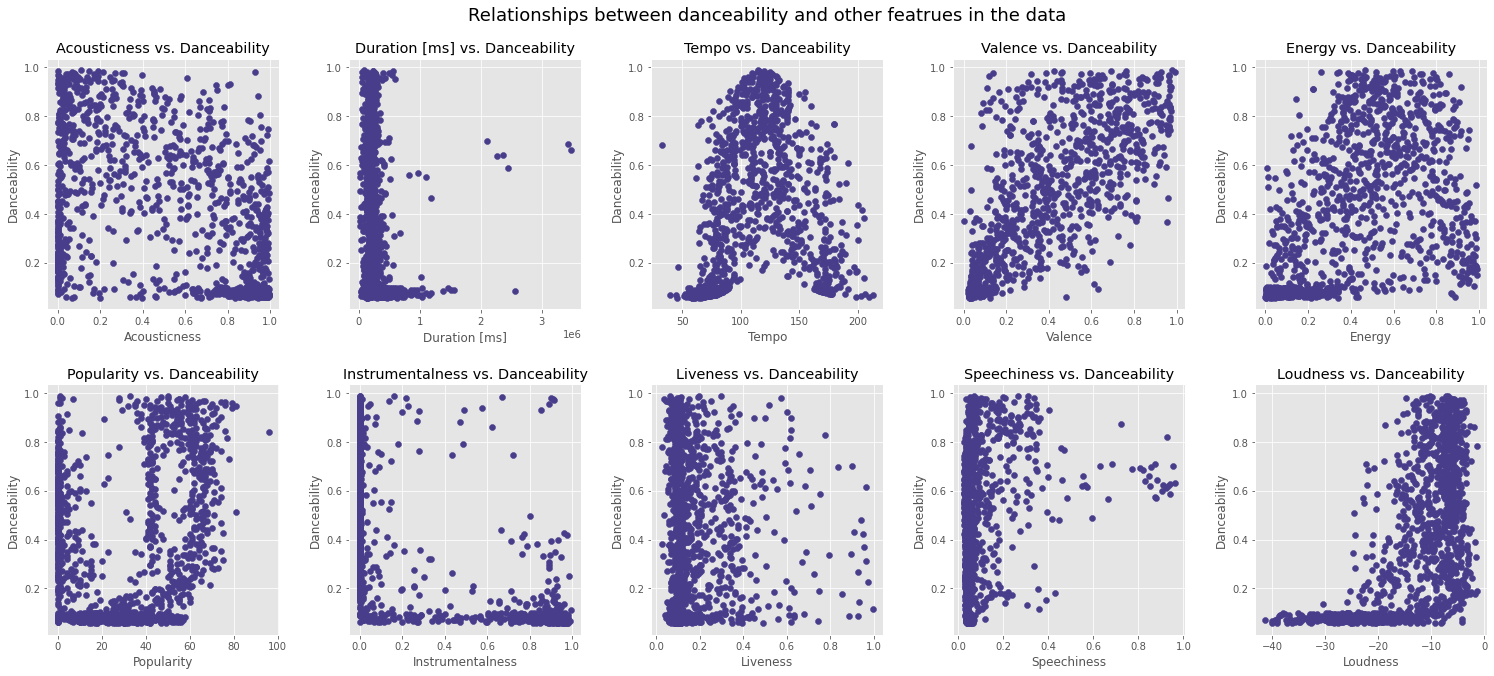

In [10]:
lis = ['acousticness', 'duration_ms','tempo','valence','energy','popularity','instrumentalness',\
       'liveness','speechiness', 'loudness']

names = ['Acousticness', 'Duration [ms]','Tempo','Valence','Energy','Popularity','Instrumentalness',\
       'Liveness','Speechiness', 'Loudness']


nrow=2
ncol=5
fig,ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(25,10))
i=0
for r in range(nrow):
    for c in range(ncol):
        df_group = new_df[[lis[i],'danceability']].sort_values(by=lis[i])
        ax[r,c].scatter(df_group[lis[i]],df_group['danceability'], color='darkslateblue') 
        ax[r,c].set_xlabel(names[i])
        ax[r,c].set_ylabel('Danceability')
        ax[r,c].title.set_text(names[i] +' vs. Danceability')
        i+=1

        
fig.text(0.5, 0.96, 'Relationships between danceability and other featrues in the data', ha='center', va='center', 
                                                                                                        fontsize=18)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3);

From the figures above, it is observed that most of the features have a non-linear trend with danceability.

Now, let's see whether there are any outliers in the numerical features of the data which could affect the outcome.

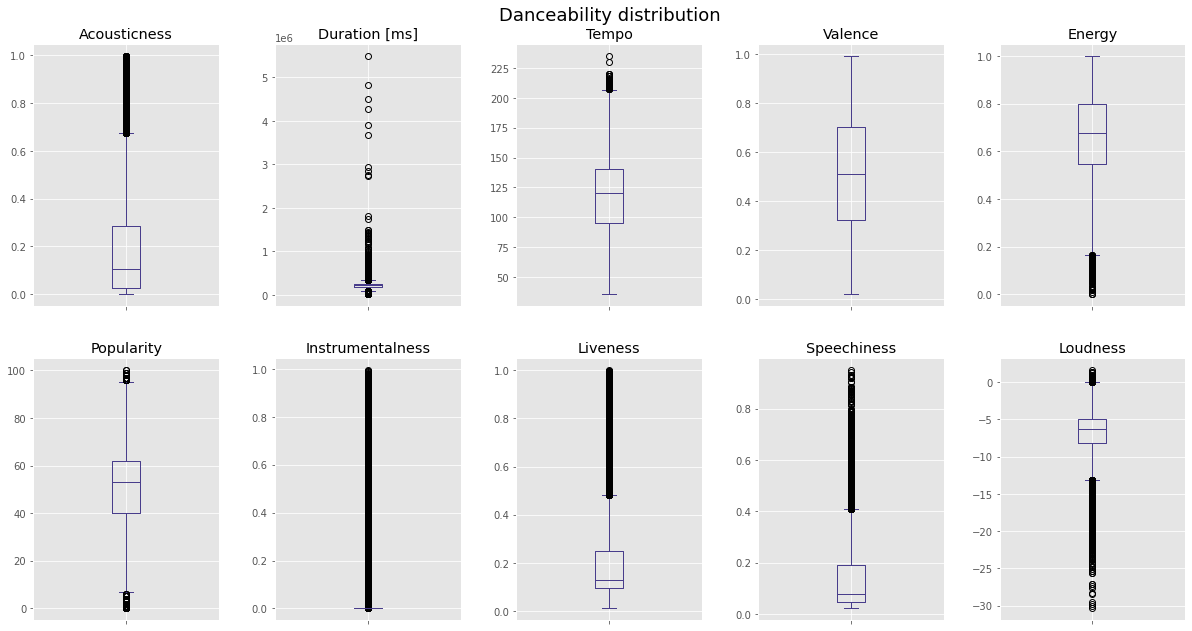

In [11]:
dfbox = data[['acousticness', 'duration_ms','tempo','valence','energy','popularity','instrumentalness',\
       'liveness','speechiness', 'loudness']]

nrow=2
ncol=5
fig,ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(25,10))
i=0

for r in range(nrow):
    for c in range(ncol):
            dfbox[lis[i]].plot(kind='box',figsize=(20,10), ax = ax[r,c], color='darkslateblue')
            ax[r,c].title.set_text(names[i])
            ax[r,c].axes.xaxis.set_ticklabels([])
            i+= 1

fig.text(0.5, 0.94, 'Danceability distribution', ha='center', va='center',fontsize=18)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2);

From this, it is observed that there are cleary a lot of outliers in duration, instrumentalness and speechiness. Duration will be the only one considered for outliers, as it is very relevant when predicting danceability. The dataset will be filtered on duration to only include songs that are 15 minutes or less, as people are hardly dancing to the same song for more than 15 minutes.


In [12]:
# change to minutes
data['duration_min']=data['duration_ms']/1000/60

# lets filter out songs which are longer than 15 minutes
data = data[data.duration_min<=15]

# Baseline Models <a class="anchor" id="chapter4"></a>

Baseline models will now be constructed for the sake of comparison. 

### Sklearn Linear Regression <a class="anchor" id="section_4_1"></a>

At first a simple linear regression was created to support an incremental approach to the problem. That allows discovery of the connection between the dependant variables (X) which were the chosen features in the dataset from the independent variable (Y), which is danceability. The linear regression model is very sufficient for easily interpretable baseline results.

Firstly, the linear regression model from the `SciKit-Learn` library will be considered.

In [13]:
y = data[['danceability']]
X = data.drop(columns=['track_id','artist_name','track_name','time_signature','duration_min','danceability'])

In [14]:
# prepare matrix with dummy features
X = pd.get_dummies(X, columns=['mode','key'])

In [15]:
# split the data for prediction
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [16]:
# prepare matrix with dummy features
X = pd.get_dummies(X, columns=['genre'])

In [17]:
# we do two separate splits as for the hierarchical models we need the data as a dataframe and without dummy variables
# random state = 42 ensures that both splits are the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [18]:
X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()

y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

In [19]:
y_baseline = y_train.mean(axis=0)

The data is standardized so all features are of the same scale. It’s considered good practice to standardize after splitting the data as doing it before can cause data leakage.

In [20]:
# standardize the data
y_mean_train = y_train.mean(axis=0)
y_std_train = y_train.std(axis=0)
y_train = (y_train - y_mean_train) / y_std_train


X_mean_train = X_train[:,:11].mean(axis=0)
X_std_train = X_train[:,:11].std(axis=0)
X_train[:,:11] = (X_train[:,:11] - X_mean_train) / X_std_train

X_test[:,:11] = (X_test[:,:11] - X_mean_train)/X_std_train

In [21]:
# linear regression model
LinReg = linear_model.LinearRegression()
LinReg.fit(X_train, y_train)
y_pred = LinReg.predict(X_test)

In [22]:
beta_sklearn = LinReg.coef_

In [23]:
# Convert back to the original scale
preds = y_pred * np.array(y_std_train) + np.array(y_mean_train)

In [24]:
# function to evaluate the models
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return mae, rae, rmse, r2

In [25]:
a = np.empty(len(y_test))
a.fill(float(y_baseline))
mae_baseline, rae_baseline, rmse_baseline, r2_baseline = compute_error(np.array(y_test), a.reshape(-1,1))

In [26]:
# evaluation of the sklearn linear regression
mae, rae, rmse, r2 = compute_error(np.array(y_test), preds)
print('Evaluation of the sklearn Linear Regression:\n')
print('MAE for the mean of y_train {:.5f}'.format(mae_baseline))
print("MAE: %.5f\nRAE: %.5f\nRMSE: %.5f\nR2: %.5f" % (mae, rae, rmse, r2))

Evaluation of the sklearn Linear Regression:

MAE for the mean of y_train 0.11084
MAE: 0.09353
RAE: 0.84433
RMSE: 0.11833
R2: 0.26160


For comparison, the error by predicting only the mean of y train is considered as it gives an idea of how well the linear model is performing. Is is observed that the linear model performs slightly better than just predicting the mean.

### Pyro Linear Regression <a class="anchor" id="section_4_2"></a>

Now, a Bayesian linear regression model will be implement in Pyro.

In [27]:
# linear regression model
def model(X, obs=None):
    alpha = pyro.sample('alpha', pyro.distributions.Normal(0., 1).to_event())
    beta = pyro.sample('beta', pyro.distributions.Normal(torch.zeros(X.shape[1]),torch.ones(X.shape[1])).to_event())
    sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(5.).to_event())
    
    with pyro.plate('data', len(X)):
        y = pyro.sample('y', pyro.distributions.Normal(alpha + torch.matmul(beta, X.T), sigma), obs=obs)
        
    return y

In [28]:
# For SVI
# Define guide function
guide = AutoNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 3000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [29]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train.T)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 74142.4
[100] ELBO: 73151.6
[200] ELBO: 68378.4
[300] ELBO: 68341.8
[400] ELBO: 67862.6
[500] ELBO: 67369.0
[600] ELBO: 68831.8
[700] ELBO: 67933.4
[800] ELBO: 65897.3
[900] ELBO: 66471.1
[1000] ELBO: 65629.4
[1100] ELBO: 65590.2
[1200] ELBO: 66080.7
[1300] ELBO: 66199.3
[1400] ELBO: 65384.6
[1500] ELBO: 65022.5
[1600] ELBO: 65185.7
[1700] ELBO: 65443.8
[1800] ELBO: 65337.4
[1900] ELBO: 65566.6
[2000] ELBO: 65291.5
[2100] ELBO: 65112.3
[2200] ELBO: 65048.1
[2300] ELBO: 64690.4
[2400] ELBO: 64818.8
[2500] ELBO: 64760.2
[2600] ELBO: 64819.4
[2700] ELBO: 64747.6
[2800] ELBO: 64712.8
[2900] ELBO: 64706.4


In [30]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma", "y"))
samples = predictive(X_test)

In [31]:
# Convert back to the original scale
y_hat = samples["y"].mean(axis=0).reshape(-1,1)
preds_pyro = y_hat * y_std_train + y_mean_train

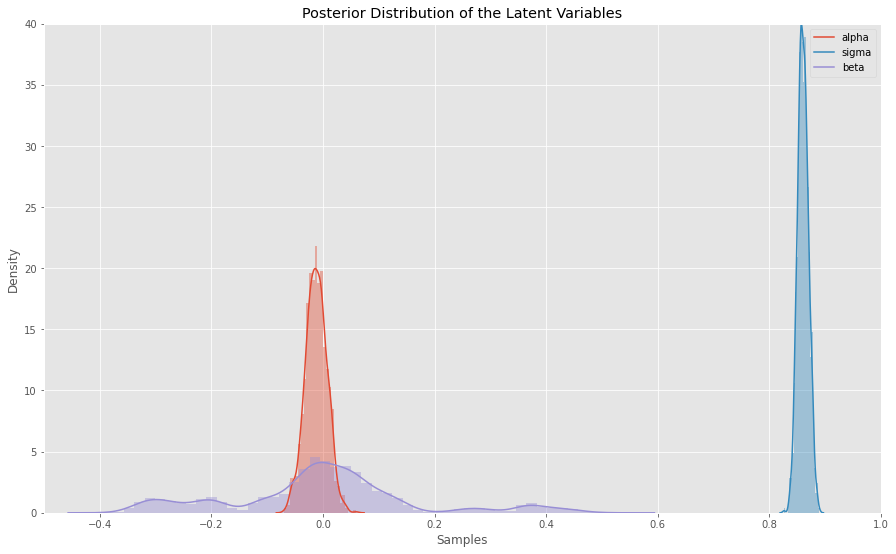

In [32]:
plt.figure(figsize=(15,9))
# Extract samples from posterior
sns.distplot(samples["alpha"])
sns.distplot(samples["sigma"])
sns.distplot(samples["beta"])

plt.legend(["alpha", "sigma", "beta"])
plt.xlabel('Samples')
plt.title('Posterior Distribution of the Latent Variables')
plt.axis([-0.5,1,0,40])
plt.show()

Here the posterior distribution over the latent variables of alpha, beta and sigma are shown. Sigma and alpha, both seem to be very deterministic, whereas beta is more evenly spread.

In [33]:
beta_pyro = samples["beta"].mean(axis=0).reshape(-1,1)

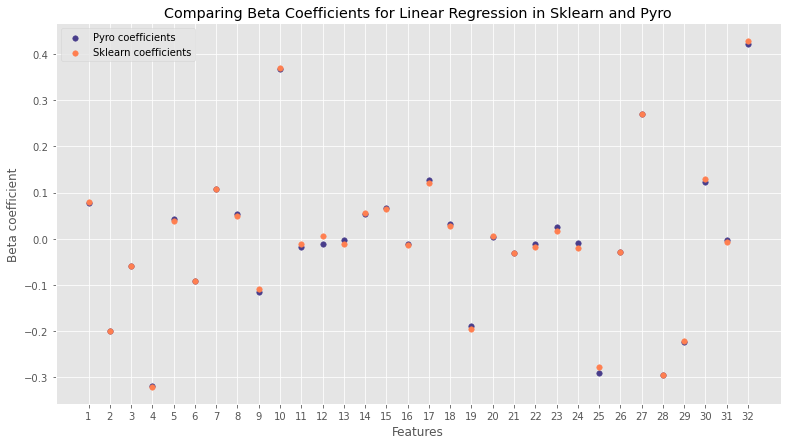

In [34]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

x = np.arange(1,len(beta_pyro)+1)

ax.scatter(x, beta_pyro, s=30, c='darkslateblue', marker="o", label='Pyro coefficients')
ax.scatter(x , beta_sklearn, s=30, c='coral', marker="o", label='Sklearn coefficients')
plt.ylabel('Beta coefficient')
plt.xlabel('Features')
plt.xticks(x)
plt.title('Comparing Beta Coefficients for Linear Regression in Sklearn and Pyro')
plt.legend(loc='upper left');

Above the beta coefficients for linear regression in sklearn and pyro are compared. The coefficients are fairly similar for both models. Feature number 10 and feature number 32 do clearly have the highest weight and are therefore of the highest important, interestingly these features are valence and the genre reggaeton, this is reasonable as reggaeton is the genre with the highest danceability and valence was the feature with the highest linear correlation.

In [35]:
mae_pyro, rae_pyro, rmse_pyro, r2_pyro = compute_error(np.array(y_test), np.array(preds_pyro))
print('Evaluation of the pyro Linear Regression:\n')
print('MAE for the mean of y_train {:.5f}'.format(mae_baseline))
print("MAE: %.5f\nRAE: %.5f\nRMSE: %.5f\nR2: %.5f" % (mae_pyro, rae_pyro, rmse_pyro, r2_pyro))

Evaluation of the pyro Linear Regression:

MAE for the mean of y_train 0.11084
MAE: 0.09353
RAE: 0.84436
RMSE: 0.11838
R2: 0.26094


In [36]:
print('Comparison for both models:\n')
print('MAE for linear regression in sklearn {:.5f}'.format(mae))
print('MAE for linear regression in pyro {:.5f}'.format(float(mae_pyro)))

Comparison for both models:

MAE for linear regression in sklearn 0.09353
MAE for linear regression in pyro 0.09353


In [139]:
X.columns[26]

'genre_Hip-Hop'

# Advanced models <a class="anchor" id="chapter5"></a>

In this section, more advanced models will be implemented in hope to accomplish a lower error.

### Neural Network <a class="anchor" id="section_5_1"></a>

Before it was observed that many of the varibles have a non-linear relationship with danceability. Therefore a Bayesian Neural Network model will be constructed. The model parameters were tuned by trial and error, sigma for the model prior was set to be 2 and the number of hidden units was set to be 10.

In [37]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

In [38]:
def nnet_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=10, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), 2*torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("y", dist.Normal(prediction_mean, 0.1), obs=y)
        
    return y

In [39]:
# Define guide function
guide = AutoDiagonalNormal(nnet_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

In [40]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train.T)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 5115574.7
[500] ELBO: 1541282.7
[1000] ELBO: 1411090.5
[1500] ELBO: 1377355.6
[2000] ELBO: 1360494.2
[2500] ELBO: 1377425.5
[3000] ELBO: 1361855.1
[3500] ELBO: 1340847.0
[4000] ELBO: 1337342.6
[4500] ELBO: 1333571.8
[5000] ELBO: 1338932.3
[5500] ELBO: 1338640.3
[6000] ELBO: 1331086.1
[6500] ELBO: 1330415.2
[7000] ELBO: 1330501.7
[7500] ELBO: 1334086.8
[8000] ELBO: 1329067.4
[8500] ELBO: 1337419.4
[9000] ELBO: 1326898.5
[9500] ELBO: 1329044.5
[10000] ELBO: 1328272.1
[10500] ELBO: 1328003.3
[11000] ELBO: 1332866.9
[11500] ELBO: 1328189.5
[12000] ELBO: 1325271.0
[12500] ELBO: 1331320.2
[13000] ELBO: 1326088.2
[13500] ELBO: 1324478.8
[14000] ELBO: 1329288.4
[14500] ELBO: 1330622.2
[15000] ELBO: 1326374.6
[15500] ELBO: 1326527.4
[16000] ELBO: 1334536.6
[16500] ELBO: 1325506.5
[17000] ELBO: 1334561.3
[17500] ELBO: 1323875.7
[18000] ELBO: 1325131.6
[18500] ELBO: 1322235.6
[19000] ELBO: 1327797.8
[19500] ELBO: 1322375.0


In [41]:
# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma", "y"))
samples = predictive(X_test)

In [42]:
# Convert back to the original scale
y_hat = samples["y"].mean(axis=0).reshape(-1,1)
preds_nn = y_hat * y_std_train + y_mean_train

In [43]:
mae_nn, rae_nn, rmse_nn, r2_nn = compute_error(np.array(y_test), np.array(preds_nn))
print('Evaluation of the Neural Network:\n')
print("MAE: %.5f\nRAE: %.4f\nRMSE: %.4f\nR2: %.4f" % (mae_nn, rae_nn, rmse_nn, r2_nn))

Evaluation of the Neural Network:

MAE: 0.07964
RAE: 0.7190
RMSE: 0.1030
R2: 0.4402


When looking at the mean absolute error, it is a clear improvement from using the linear models. 

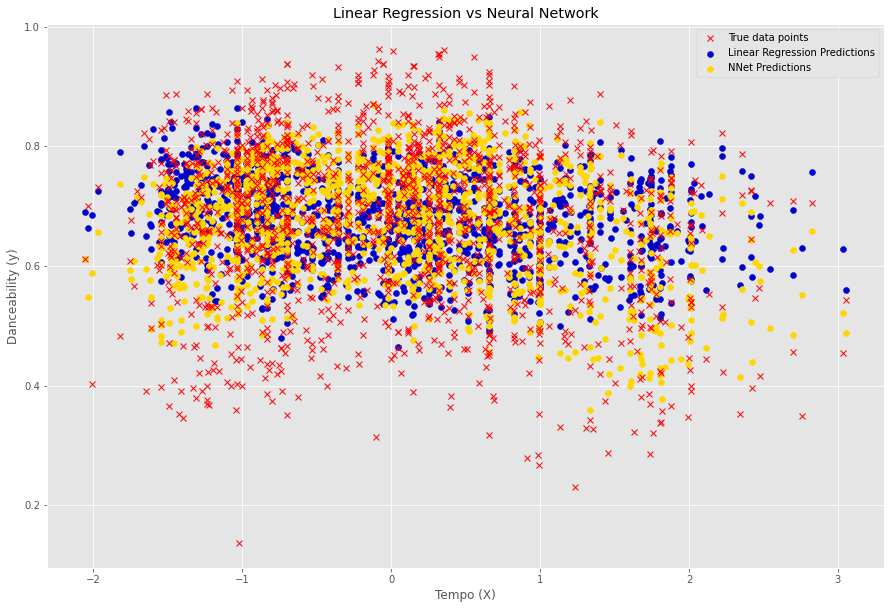

In [116]:
plt.figure(figsize=(15,10))
plt.plot(X_test[:,8][:1500], y_test[:1500], "rx")
plt.scatter(X_test[:,8][:1500], preds_pyro[:1500], color='mediumblue')
plt.scatter(X_test[:,8][:1500], preds_nn[:1500], color='gold')
plt.legend(["True data points", "Linear Regression Predictions", "NNet Predictions"])
plt.title('Linear Regression vs Neural Network')
plt.ylabel('Danceability (y)')
plt.xlabel('Tempo (X)');

In the figure above a small subset of the predictions and the real values for both the linear regression and the neural network model can be seen plotted with the tempo feature as an example. Again, it's clear that the neural network does better predictions than the linear model.

### Neural Network + Linear Regression  <a class="anchor" id="section_5_2"></a>

Here the Bayesian neural network will be extended with a linear regression, to see if it further improves the prediction.

In [45]:
def nnet_interpretable_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1]-1, n_hidden=10, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        # Each parameter has a N(0, 1) prior
        priors[name] = dist.Normal(torch.zeros(*par.shape), 2*torch.ones(*par.shape)).to_event() 
    # Make this model and these priors a Pyro model
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) 
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(0, 1))
    
    # The generative process
    with pyro.plate("observations"):
        linear_out = X[:,0]*beta_lin
        nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("y", dist.Normal(linear_out+nn_out, 0.1), obs=y)
        
    return y

In [46]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model, guide, optimizer, loss=elbo)

In [47]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train.T)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 11838230.0
[500] ELBO: 1498245.0
[1000] ELBO: 1426614.3
[1500] ELBO: 1377908.5
[2000] ELBO: 1400298.9
[2500] ELBO: 1345699.9
[3000] ELBO: 1342265.6
[3500] ELBO: 1345994.7
[4000] ELBO: 1328931.1
[4500] ELBO: 1337447.1
[5000] ELBO: 1322562.9
[5500] ELBO: 1323377.5
[6000] ELBO: 1327662.4
[6500] ELBO: 1320041.1
[7000] ELBO: 1318288.6
[7500] ELBO: 1317502.2
[8000] ELBO: 1325699.1
[8500] ELBO: 1317786.5
[9000] ELBO: 1317243.0
[9500] ELBO: 1318186.8
[10000] ELBO: 1315067.3
[10500] ELBO: 1314801.5
[11000] ELBO: 1325792.5
[11500] ELBO: 1316221.7
[12000] ELBO: 1314494.5
[12500] ELBO: 1313427.1
[13000] ELBO: 1312722.7
[13500] ELBO: 1313261.8
[14000] ELBO: 1316491.7
[14500] ELBO: 1311896.4
[15000] ELBO: 1318604.1
[15500] ELBO: 1314755.7
[16000] ELBO: 1313534.1
[16500] ELBO: 1318501.6
[17000] ELBO: 1319472.2
[17500] ELBO: 1313800.6
[18000] ELBO: 1312121.0
[18500] ELBO: 1315054.5
[19000] ELBO: 1312232.1
[19500] ELBO: 1322581.1


In [48]:
# Make predictions for test set
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma", "y"))
samples = predictive(X_test)

In [49]:
# Convert back to the original scale
y_hat = samples["y"].mean(axis=0).reshape(-1,1)
preds_nn_lin = y_hat * y_std_train + y_mean_train

In [50]:
mae_nn_lin, rae_nn_lin, rmse_nn_lin, r2_nn_lin = compute_error(np.array(y_test), np.array(preds_nn_lin))
print('Evaluation of the Neural Network + Linear regression:\n')
print("MAE: %.5f\nRAE: %.4f\nRMSE: %.4f\nR2: %.4f" % (mae_nn_lin, rae_nn_lin, rmse_nn_lin, r2_nn_lin))

Evaluation of the Neural Network + Linear regression:

MAE: 0.08015
RAE: 0.7235
RMSE: 0.1028
R2: 0.4428


Here is the evaluation for the neural network + linear regression model. Adding the linear factor results in a very similar model to the non-linear neural network.

### Hierarchial Models <a class="anchor" id="section_5_3"></a>

Now, hierarchial models will be implemented. Alpha will differ depending on which musical genre the particular song belongs to.

#### Hierarchial priors for the intercept $\alpha$ <a class="anchor" id="section_5_3_1"></a>

First, a linear model was constructed with hierarchial priors for the intercept $\alpha$. Instead of a single intercept $\alpha$ for all songs, we have a vector of intercepts $\boldsymbol{\alpha} = [\alpha_1,...,\alpha_G]$ where G is the number of genres. 

In [51]:
def hierarchical_linear_model_intercept(X, genre, n_genre, obs=None):
    input_dim = X.shape[1]
    
    
    
    alpha_mu = pyro.sample("alpha_mu", pyro.distributions.Normal(0.,0.5).to_event()) # Prior for the bias mean
    
    alpha_sigma  = pyro.sample("alpha_sigma",  pyro.distributions.HalfCauchy(4).to_event()) # Prior for the bias standard deviation
    
    beta = pyro.sample("beta", pyro.distributions.Normal(torch.zeros(input_dim), 
                                           4.*torch.ones(input_dim)).to_event()) 

    with pyro.plate("ind", n_genre):
        alpha = pyro.sample("alpha", pyro.distributions.Normal(alpha_mu, alpha_sigma).to_event()) # Draw different alpha for each genre
        
    with pyro.plate("data", X.shape[0]):
        

        linear = alpha[genre] + X.matmul(beta.squeeze(0).T)
   
        y = pyro.sample("y", pyro.distributions.Normal(linear,1), obs=obs) 
        
    return y

In [52]:
le = preprocessing.LabelEncoder()
genre_list = X_train1['genre'].unique()
le.fit(genre_list)
X_train1['genre_LE'] = le.transform(X_train1.genre)

genre_ind_train=np.array(X_train1['genre_LE'])
n_genres = genre_ind_train.max()


X_train1=X_train1.drop(columns=['genre','genre_LE'],axis=1).values
y_train1=y_train1.values


X_train1=torch.tensor(X_train1.squeeze()).float()
y_train1=torch.tensor(y_train1).T.float()


X_mean=X_train1.mean(axis=0)
X_std = X_train1.std(axis=0)
X_train1 = (X_train1-X_mean)/X_std

y_mean_train = y_train1.mean(axis=1)
y_std_train = y_train1.std(axis=1)
y_train1 = (y_train1 - y_mean_train) / y_std_train

In [80]:
# Define guide function
guide = AutoNormal(hierarchical_linear_model_intercept)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_linear_model_intercept, guide, optimizer, loss=elbo)

In [81]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train1, genre_ind_train, n_genres+1, y_train1)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 74235.4
[100] ELBO: 67237.7
[200] ELBO: 66067.2
[300] ELBO: 66058.4
[400] ELBO: 65944.1
[500] ELBO: 65797.5
[600] ELBO: 65713.6
[700] ELBO: 65705.3
[800] ELBO: 65720.0
[900] ELBO: 65706.4
[1000] ELBO: 65707.6
[1100] ELBO: 65718.6
[1200] ELBO: 65686.6
[1300] ELBO: 65717.9
[1400] ELBO: 65712.8
[1500] ELBO: 65699.3
[1600] ELBO: 65724.3
[1700] ELBO: 65709.2
[1800] ELBO: 65699.3
[1900] ELBO: 65712.6
[2000] ELBO: 65703.8
[2100] ELBO: 65687.3
[2200] ELBO: 65711.7
[2300] ELBO: 65709.6
[2400] ELBO: 65729.2
[2500] ELBO: 65696.7
[2600] ELBO: 65711.0
[2700] ELBO: 65696.5
[2800] ELBO: 65700.0
[2900] ELBO: 65703.1
[3000] ELBO: 65694.3
[3100] ELBO: 65741.6
[3200] ELBO: 65714.2
[3300] ELBO: 65709.6
[3400] ELBO: 65704.9
[3500] ELBO: 65706.1
[3600] ELBO: 65697.2
[3700] ELBO: 65702.6
[3800] ELBO: 65710.4
[3900] ELBO: 65726.9


In [55]:
le = preprocessing.LabelEncoder()
genre_list = X_test1['genre'].unique()
le.fit(genre_list)
X_test1['genre_LE'] = le.transform(X_test1.genre)

genre_ind_test=np.array(X_test1['genre_LE'])
n_genres = genre_ind_test.max()



X_test1=X_test1.drop(columns = ['genre','genre_LE'],axis=1).values
y_test1=y_test1.values


X_test1=torch.tensor(X_test1).float()
y_test1=torch.tensor(y_test1).T.float()


X_test1 = (X_test1-X_mean)/X_std


In [82]:
predictive = Predictive(hierarchical_linear_model_intercept, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "y"))
samples = predictive(X_test1,genre_ind_test, n_genres+1,obs=None)

In [83]:
# Convert back to the original scale
y_hat = samples["y"].mean(axis=0).reshape(-1,1)

preds_lin_hier_alpha = y_hat * y_std_train + y_mean_train

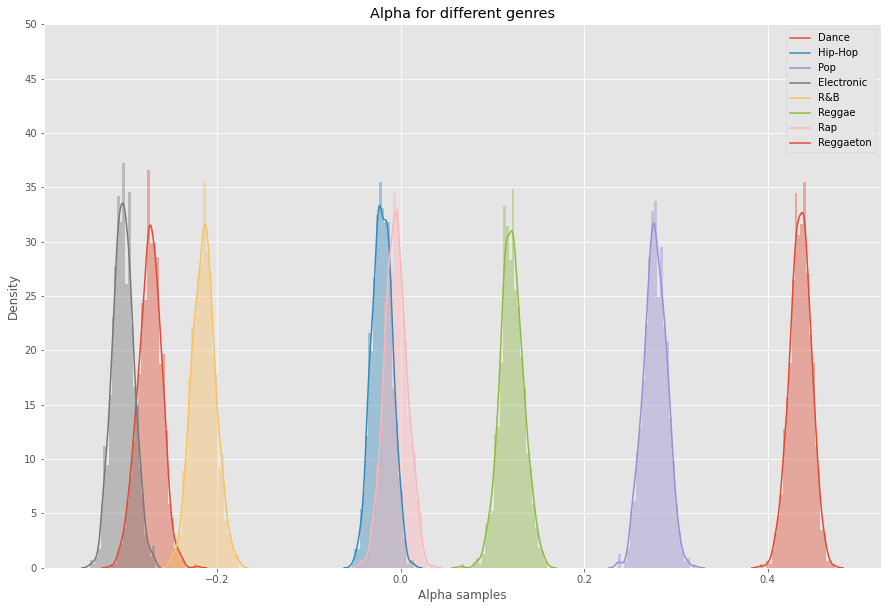

In [140]:
plt.figure(figsize=(15,10))
for c in range(n_genres+1):
    fig = sns.distplot(samples['alpha'][:,c])
plt.yticks(range(0,55,5))
plt.title('Alpha for different genres')
plt.xlabel('Alpha samples')
fig.legend([c for c in genre_list]);

The figure above visualizes the alpha for different genres. The alpha samples indicates that there is indeed a variation between genres.

In [58]:
mae_lin_hier_alpha, rae_lin_hier_alpha, rmse_lin_hier_alpha, r2_lin_hier_alpha = \
            compute_error(np.array(y_test1.T), np.array(preds_lin_hier_alpha))
print('Evaluation of the Lineaer Model with Hierarchial priors 𝛼:\n')
print("MAE: %.5f\nRAE: %.4f\nRMSE: %.4f\nR2: %.4f" % (mae_lin_hier_alpha, rae_lin_hier_alpha,\
                                                      rmse_lin_hier_alpha, r2_lin_hier_alpha))

Evaluation of the Lineaer Model with Hierarchial priors 𝛼:

MAE: 0.09361
RAE: 0.8451
RMSE: 0.1184
R2: 0.2612


Having hierarchial $\alpha$ for the linear model does not seem to improve the model at all, and has an even higher error than the original linear model. Perhaps the intercept $\alpha$ does not have much impact on the model, which is unexpected as the alpha clearly differs between genres. Perhaps the difference of the samples could be arbitrary.

#### Hierarchial priors for $\alpha$ and $\beta$ <a class="anchor" id="section_5_3_2"></a>

As the model above did not show improved results, a more advance model will be implemented, with both hierarchial $\alpha$ and $\beta$.

In [59]:
def hierarchical_linear_model_beta(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]
    
    alpha = pyro.sample('alpha', pyro.distributions.Normal(0., 0.5).to_event())
    beta_mu = pyro.sample("beta_mu", pyro.distributions.Normal(torch.zeros(input_dim), 
                                            4.*torch.ones(input_dim)).to_event()) # Prior for the bias mean
    beta_sigma  = pyro.sample("beta_sigma",  pyro.distributions.HalfCauchy(4.*torch.ones(input_dim)).to_event()) # Prior for the bias standard deviation

    with pyro.plate("ind", n_ind):
       # alpha = pyro.sample("alpha", pyro.distributions.Normal(alpha_mu, alpha_sigma).to_event()) # Draw the individual parameter for each genre 
        beta  = pyro.sample("beta", pyro.distributions.Normal(beta_mu, beta_sigma).to_event()) # Draw the individual parameter for each genre 
    
    y = torch.zeros(X.shape[0])
    
    for i in pyro.plate("data",X.shape[0]):
        
        index = ind[i]
        linear = alpha + X[i].matmul(beta[index].T)        
        
        if obs != None:
            y[i] = pyro.sample("y_%d"%i, pyro.distributions.Normal(linear, 1.),obs=obs[i])
        else:
            
            y[i] = pyro.sample("y_%d"%i, pyro.distributions.Normal(linear, 1.),obs=obs)
        
    return y

In [60]:
# Define guide function
guide = AutoNormal(hierarchical_linear_model_beta)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 1000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_linear_model_beta, guide, optimizer, loss=elbo)

In [61]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train1, genre_ind_train, n_genres+1, y_train1.T)
    if step % 10 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 84852.2
[10] ELBO: 72741.3
[20] ELBO: 72816.4
[30] ELBO: 71443.6
[40] ELBO: 69443.5
[50] ELBO: 70980.0
[60] ELBO: 69246.0
[70] ELBO: 68861.2
[80] ELBO: 68071.4
[90] ELBO: 68092.4
[100] ELBO: 67433.8
[110] ELBO: 67447.5
[120] ELBO: 67568.2
[130] ELBO: 67039.7
[140] ELBO: 67228.2
[150] ELBO: 66905.9
[160] ELBO: 67103.8
[170] ELBO: 66691.6
[180] ELBO: 66387.7
[190] ELBO: 66579.0
[200] ELBO: 66431.2
[210] ELBO: 66308.7
[220] ELBO: 66340.3
[230] ELBO: 66402.8
[240] ELBO: 66133.2
[250] ELBO: 66319.8
[260] ELBO: 66079.3
[270] ELBO: 66123.0
[280] ELBO: 66056.0
[290] ELBO: 66092.0
[300] ELBO: 65966.4
[310] ELBO: 66021.5
[320] ELBO: 65959.3
[330] ELBO: 66000.9
[340] ELBO: 65845.5
[350] ELBO: 65886.5
[360] ELBO: 65900.7
[370] ELBO: 65870.6
[380] ELBO: 65859.8
[390] ELBO: 65789.5
[400] ELBO: 65778.7
[410] ELBO: 65828.4
[420] ELBO: 65741.1
[430] ELBO: 65750.9
[440] ELBO: 65755.6
[450] ELBO: 65790.6
[460] ELBO: 65782.8
[470] ELBO: 65741.6
[480] ELBO: 65738.0
[490] ELBO: 65736.6
[500] ELBO:

In [62]:
predictive = Predictive(hierarchical_linear_model_beta, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma", "y"))
samples = predictive(X_test1,genre_ind_test, n_genres+1,obs=None)

In [63]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

y_hat = np.zeros(X_test1.shape[0])

for i in range(X_test1.shape[0]):
        index = genre_ind_test[i]   
        y_hat[i]= alpha_hat + np.dot(X_test1[i],beta_hat[index].T)

preds_lin_hier_beta = y_hat * float(y_std_train) + float(y_mean_train)


In [66]:
mae_hier_lin_beta, rae_hier_lin_beta, rmse_hier_lin_beta, r2_hier_lin_beta = \
            compute_error(np.array(y_test1.T), np.array(preds_lin_hier_beta.reshape(-1,1)))
print('Evaluation of the Lineaer Model with Hierarchial priors 𝛼 and 𝛽 :\n')
print("MAE: %.5f\nRAE: %.4f\nRMSE: %.4f\nR2: %.4f" % (mae_hier_lin_beta,rae_hier_lin_beta, rmse_hier_lin_beta, 
                                                                                                  r2_hier_lin_beta))

Evaluation of the Lineaer Model with Hierarchial priors 𝛼 and 𝛽 :

MAE: 0.09275
RAE: 0.8373
RMSE: 0.1177
R2: 0.2693


These results indicate that there is clearly not much improvement by extending the model with hierarchical beta.

#### Hierachial $\alpha$ -  Neural Network + Linear Regression  <a class="anchor" id="section_5_3_3"></a>

Now a non-linear factor will be added to the hirearchical $\alpha$ model

In [68]:
def hierarchical_model_nn_linear(X, U, ind, n_genres, obs=None):
    input_dim = X.shape[1]
    n_obs = X.shape[0]
    
     
    alpha_mu = pyro.sample("alpha_mu", pyro.distributions.Normal(0.,0.5).to_event()) # Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma",  pyro.distributions.HalfCauchy(4).to_event()) # Prior for the bias standard deviation
    
    beta = pyro.sample("beta", pyro.distributions.Normal(torch.zeros(input_dim), 
                                           4.*torch.ones(input_dim)).to_event()) 
    alpha = torch.zeros(n_genres)
    for i in range(n_genres):
        alpha[i] = pyro.sample("alpha_%d"%i, dist.Normal(alpha_mu, alpha_sigma).to_event()) # Draw the individual parameter for each individual
     
    torch_model = FFNN(n_in=input_dim-1, n_hidden=10, n_out=1) 

    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        # Each parameter has a N(0, 1) prior
        priors[name] = dist.Normal(torch.zeros(*par.shape), 2*torch.ones(*par.shape)).to_event() 
    # Make this model and these priors a Pyro model
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) 
    sampled_model = bayesian_model()       
    
    with pyro.plate("observations", n_obs):
        linear_out = alpha[ind] + X.matmul(beta.T)
        nn_out = sampled_model(U[:,1:]).squeeze(-1)
        y = pyro.sample("obs", dist.Normal(linear_out+nn_out, 1), obs=obs)
            
    return y

In [69]:
# Define guide function
guide = AutoNormal(hierarchical_model_nn_linear)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 2000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_model_nn_linear , guide, optimizer,loss=elbo)


# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train1, X_train1, genre_ind_train, n_genres+1, y_train1)
    if step % 10 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))


[0] ELBO: 83676.5
[10] ELBO: 74546.8
[20] ELBO: 75910.8
[30] ELBO: 71663.2
[40] ELBO: 71163.9
[50] ELBO: 70277.2
[60] ELBO: 71629.6
[70] ELBO: 70924.7
[80] ELBO: 68126.4
[90] ELBO: 69863.1
[100] ELBO: 69626.5
[110] ELBO: 69343.4
[120] ELBO: 68141.0
[130] ELBO: 67398.9
[140] ELBO: 67783.1
[150] ELBO: 68276.5
[160] ELBO: 67245.7
[170] ELBO: 67975.5
[180] ELBO: 67653.5
[190] ELBO: 67651.1
[200] ELBO: 67157.5
[210] ELBO: 67041.8
[220] ELBO: 66972.9
[230] ELBO: 67476.9
[240] ELBO: 67058.4
[250] ELBO: 67052.8
[260] ELBO: 66854.2
[270] ELBO: 67622.3
[280] ELBO: 67645.4
[290] ELBO: 66872.7
[300] ELBO: 67028.2
[310] ELBO: 66668.3
[320] ELBO: 66873.7
[330] ELBO: 66816.1
[340] ELBO: 66929.5
[350] ELBO: 66646.1
[360] ELBO: 66946.7
[370] ELBO: 66572.3
[380] ELBO: 66737.1
[390] ELBO: 66606.6
[400] ELBO: 66573.0
[410] ELBO: 66675.6
[420] ELBO: 66537.5
[430] ELBO: 66569.9
[440] ELBO: 66842.6
[450] ELBO: 66609.6
[460] ELBO: 66601.8
[470] ELBO: 66713.1
[480] ELBO: 66400.5
[490] ELBO: 66403.5
[500] ELBO:

In [70]:
predictive = Predictive(hierarchical_model_nn_linear, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test1,X_test1,genre_ind_test, n_genres+1,obs=None)

In [71]:
# Convert back to the original scale
y_hat = samples["obs"].mean(axis=0).reshape(-1,1)
preds_lin_hier_nn = y_hat * y_std_train + y_mean_train

In [72]:
mae_lin_hier_nn, rae_lin_hier_nn, rmse_lin_hier_nn, r2_lin_hier_nn = \
            compute_error(np.array(y_test1.T), np.array(preds_lin_hier_nn))
print('Evaluation of the Neural Network + Lineaer Model with Hierarchial priors 𝛼:\n')
print("MAE: %.5f\nRAE: %.4f\nRMSE: %.4f\nR2: %.4f" % (mae_lin_hier_nn, rae_lin_hier_nn,\
                                                      rmse_lin_hier_nn, r2_lin_hier_nn))

Evaluation of the Neural Network + Lineaer Model with Hierarchial priors 𝛼:

MAE: 0.08365
RAE: 0.7552
RMSE: 0.1064
R2: 0.4029


This results in slight improvement from the previos hierachical model but still does not outperform the simple neural network model

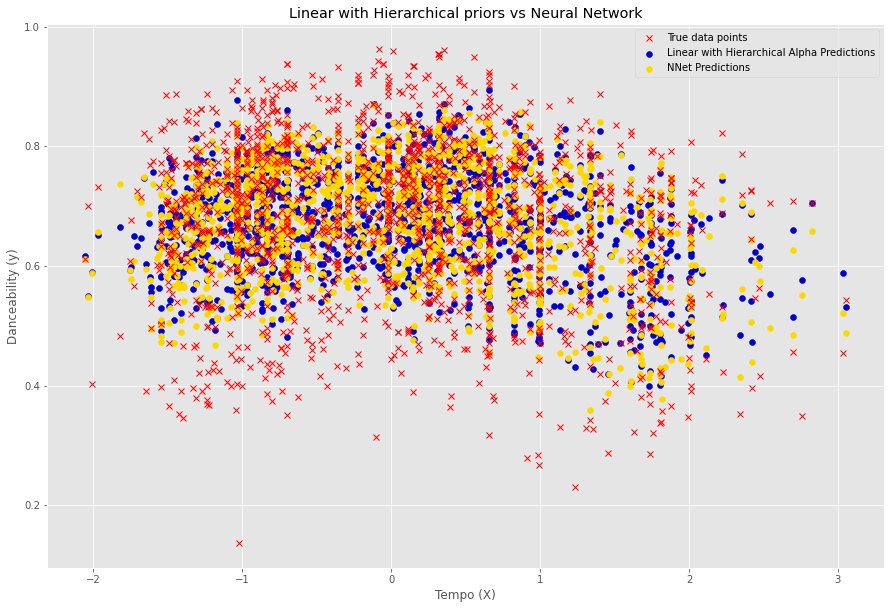

In [124]:
plt.figure(figsize=(15,10))
plt.plot(X_test[:,8][:1500], y_test[:1500], "rx")
plt.scatter(X_test1[:,8][:1500], preds_lin_hier_nn[:1500], color='mediumblue')
plt.scatter(X_test[:,8][:1500], preds_nn[:1500], color='gold')
plt.legend(["True data points", "Linear with Hierarchical Alpha Predictions", "NNet Predictions"])
plt.title('Linear with Hierarchical priors vs Neural Network')
plt.ylabel('Danceability (y)')
plt.xlabel('Tempo (X)');

The figure above shows that the neural network predictions are closer to the true data points compared to the linear model with hierarchical Alpha predictions

# Discussion <a class="anchor" id="chapter6"></a>

In [76]:
print('Evaluation of all models:\n')
print('MAE for the mean of y_train {:.5f}'.format(mae_baseline))
print('MAE for Linear Regression in Sklearn {:.5f}'.format(mae))
print('MAE for Linear Regression in Pyro {:.5f}'.format(float(mae_pyro)))
print('MAE for Neural Network {:.5f}'.format(mae_nn))
print('MAE for Neural Network + Linear Regression {:.5f}'.format(mae_nn_lin))
print('MAE for Linear Regression with Hierarchial priors 𝛼 {:.5f}'.format(mae_lin_hier_alpha))
print('MAE for Linear Regression with Hierarchial priors 𝛼 and 𝛽 {:.5f}'.format(mae_hier_lin_beta))
print('MAE for Neural Network + Linear Regression with Hierarchial priors 𝛼 {:.5f}'.format(mae_lin_hier_nn))

Evaluation of all models:

MAE for the mean of y_train 0.11084
MAE for Linear Regression in Sklearn 0.09353
MAE for Linear Regression in Pyro 0.09353
MAE for Neural Network 0.07964
MAE for Neural Network + Linear Regression 0.08015
MAE for Linear Regression with Hierarchial priors 𝛼 0.09361
MAE for Linear Regression with Hierarchial priors 𝛼 and 𝛽 0.09275
MAE for Neural Network + Linear Regression with Hierarchial priors 𝛼 0.08365


The primary results acquired in regards to the performance of different models when predicting danceability are presented here above. The Mean Absolute Error are assessed it is a good metrics to measure accuracy for continuous variables.

A surprising observation is that the simple neural network model seems to outperform all the other models, with a Mean Absolute Error of 0.0796. 

Another interesting finding it that the hierarchical model performed better after extending the model with non-linearity. When adding the hierarchical priors for beta, the model did not improve much, which was unexpected. Even thought the model was not refined the latent distribution of the alpha samples indicated that there is a variation between genres.

Finally, the results from the weights of the linear regression, imply that the most important features were valence, reggaeton and hip-hop. This is coherent as reggaeton and hip hop are the two most genres with the highest mean danceability. Spotify states that valence describes musical positiveness conveyed by a track which evidently makes people want to dance [ref: Valence](https://community.spotify.com/t5/Spotify-for-Developers/Valence-as-a-measure-of-happiness/td-p/4385221)

# References <a class="anchor" id="chapter7"></a>

[1] “Valence as a measure of happiness” [Online]. Available: https://community.spotify.com/t5/Spotify-for-Developers/Valence-as-a-measure-of-happiness/td-p/4385221

# Contributions <a class="anchor" id="chapter8"></a>